In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torchvision
from torch import nn, autograd, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.autograd import grad
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
device_ids = [0]

In [7]:
BATCH_SIZE = 128 # 256
num_epochs = 100

z_dimension = 100
num_feature = (64, 4, 4)

img_shape = (1, 32, 32)

In [8]:
img_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
#     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
#     transforms.Normalize((0.1307,), (0.3081,))
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST('~/data/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [9]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [10]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(1, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.to(device)
    
#     fake_data = fake_data.view(BATCH_SIZE, 3, DIM, DIM)
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates, _ = netD(interpolates)
    
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.shape).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)                              
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return gradient_penalty

In [11]:
def gen_noise_label(batch_size):
    label = np.random.randint(0, 10, batch_size)
    #prefix = np.zeros((batch_size, 10))
    #prefix[np.arange(batch_size), label] = 1
    return label # prefix

In [12]:
def gen_noise(batch_size, label):
    prefix = np.zeros((batch_size, 10))
    prefix[np.arange(batch_size), label] = 1
    z = np.random.normal(0, 1, (batch_size, z_dimension))
    prefix = prefix / np.linalg.norm(prefix)
    z[:, :10] = prefix
    return torch.from_numpy(z).float().to(device)

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
#         self.label_embedding = nn.Embedding(10, np.prod(img_shape))
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2), 
        ) # b 16 16 16
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2), 
        ) # b 32 8 8
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2), 
        ) # b 64 4 4
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2), 
        ) # b 128 2 2
        
        self.fc = nn.Sequential(
            nn.Linear(256 * 2 * 2, 1024),
            nn.LeakyReLU(.2, True),
            nn.Linear(1024, 1),
#             nn.Sigmoid(),
        ) # b 1
        
        self.label = nn.Sequential(
            nn.Linear(256 * 2 * 2, 10),
#             nn.Sigmoid()
        )

    def forward(self, imgs): # b 1 32 32
        
#         if(fake_labels is None):
#             _imgs = torch.cat((imgs, self.label_embedding(real_labels).reshape(imgs.size(0), *img_shape)), 1)
#         else:
#             _labs = self.label_embedding(real_labels).reshape(imgs.size(0), *img_shape) + self.label_embedding(real_labels).reshape(imgs.size(0), *img_shape)
#             _imgs = torch.cat((imgs, _labs), 1)

        outs = self.conv1(imgs)
        outs = self.conv2(outs)
        outs = self.conv3(outs)
        outs = self.conv4(outs)
        outs = outs.view(imgs.size(0), -1)
        img = self.fc(outs)
        lab = self.label(outs)
        
        return img, lab # b 1 1 1, b 10

In [14]:
class Generator(nn.Module):
    def __init__(self, inp_dim, num_feature):
        super(Generator, self).__init__()

#         self.label_emb = nn.Embedding(inp_dim, inp_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, np.prod(num_feature)),
#             nn.Sigmoid(),
        ) # b *num_feature  b 32 4 4
        
        self.upsample1 = nn.Sequential(
#             nn.BatchNorm2d(128),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
#             nn.functional.interpolate(scale_factor=2),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2, True),
#             nn.ReLU(True),
        ) # b 16 8 8
        
        self.upsample2 = nn.Sequential(
#             nn.functional.interpolate(scale_factor=2),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, 0),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(16, 8, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(.2, True),
#             nn.ReLU(True),
        ) # b 8 16 16
        
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 4, 2, 1),
#             nn.functional.interpolate(scale_factor=2),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(8, 4, 3, padding=1, stride=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(.2, True),
#             nn.ReLU(True),
        ) # b 4 32 32
        
        self.conv = nn.Sequential(
#             nn.functional.interpolate(scale_factor=2),
            nn.Conv2d(8, 1, 3, padding=1, stride=1),
            nn.Tanh(),
        ) # b 1 32 32

    def forward(self, noise):
        
#         gen_input = torch.cat((labels.reshape(noise.size(0), -1), noise), -1)
#         gen_input = torch.cat((self.label_emb(labels), noise), -1)
#         gen_input = self.label_emb(noise)
        
        outs = self.fc(noise)
        outs = outs.view(noise.size(0), *num_feature)
        outs = self.upsample1(outs)
        outs = self.upsample2(outs)
        outs = self.upsample3(outs)

        outs = self.conv(outs)
        
        return outs


In [15]:
D = Discriminator().to(device)
G = Generator(z_dimension, num_feature).to(device)

# D.weight_init(.0, 0.02)
# G.weight_init(.0, 0.02)

D = nn.DataParallel(D, device_ids=device_ids).to(device)
G = nn.DataParallel(G, device_ids=device_ids).to(device)

criterion = nn.CrossEntropyLoss()

d_optimezer = optim.Adam(D.parameters(), lr=2e-4, betas=(0, 0.9))
g_optimezer = optim.Adam(G.parameters(), lr=2e-4, betas=(0, 0.9))

one = torch.FloatTensor([1])
mone = one * -1
one = one.to(device)
mone = mone.to(device)

In [16]:
writer = SummaryWriter('./log/cnn_condition_wgan_gp')

In [17]:
img_path = "save_images/cnn_condition_wgan_img"
if not os.path.exists(img_path): os.makedirs(img_path)

In [18]:
condition_label = np.arange(10)
# condition_noise = np.random.randn(condition_label.shape[0], z_dimension)
# condition_noise[:, 0] += condition_label
# # condition_noise = condition_noise / np.linalg.norm(condition_noise)
# condition_noise = torch.from_numpy(condition_noise).float()
condition_noise = gen_noise(condition_label.shape[0], condition_label)

In [ ]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    w_dist_total = .0
    for i, (imgs, labs) in enumerate(dataloader):
        
        real_imgs = imgs.cuda()
        real_labs = labs.cuda()
        
        z = np.random.randn(imgs.size(0), z_dimension)
        fake_labels = np.random.randint(0, 10, imgs.shape[0])
#         z[:, 0] += fake_labels
# #         z = z / np.linalg.norm(z)
#         z = torch.from_numpy(z).float().cuda()
        z = gen_noise(z.shape[0], fake_labels)
        ########## G ##########
#         for p in D.parameters():
#             p.requires_grad_(False)
        
        fake_imgs = G(z)
        fake_out, fake_out_labels = D(fake_imgs)
        fake_labels_loss = criterion(fake_out_labels, torch.from_numpy(fake_labels).cuda()).mean()
        fake_cost = fake_out.mean()
        g_loss = 1 * fake_labels_loss + fake_cost

        g_optimezer.zero_grad()
        g_loss.backward(mone)
        g_loss = -g_loss
        g_optimezer.step()
        #######################
        
        
        ########## D ##########
#         for p in D.parameters():
#             p.requires_grad_(True)
        
        real_out, real_labels = D(real_imgs)
        real_labels_loss = criterion(real_labels, real_labs)
        d_loss_real_labels = real_labels_loss.mean()
        d_loss_real = real_out.mean()
        real_scores = real_out
        
        fake_out, fake_out_labels = D(fake_imgs.detach())
#         d_loss_fake_labels = criterion(fake_out_labels, torch.from_numpy(fake_labels).cuda()).mean()
        d_loss_fake = fake_out.mean()
        fake_scores = fake_out
        
        gradient_penalty = calc_gradient_penalty(D, real_imgs, fake_imgs)
        
        d_loss = d_loss_fake - d_loss_real + gradient_penalty # + 1 * d_loss_real_labels
        
        d_optimezer.zero_grad()
#         d_loss.backward()
        (d_loss + 1 * (d_loss_real_labels)).backward() # + d_loss_fake_labels
        d_optimezer.step()
        #######################
        
        w_dist = d_loss_fake - d_loss_real
        
        d_loss_total += d_loss.item() * imgs.size(0)
        g_loss_total += g_loss.item() * imgs.size(0)
        w_dist_total += w_dist * imgs.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
            writer.add_scalar('Wasserstein Distance', w_dist.item(), step)
        
        
        if (i + 1) % 300 == 0:
            tqdm.write('  Epoch[{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f} real_scores: {:.6f}' \
', fake_scores: {:.6f}, W: {:.6f}'.format(epoch+1, num_epochs, 
                                          (i+1) * BATCH_SIZE, 
                                          d_loss, g_loss, 
                                          real_scores.mean(), 
                                          fake_scores.mean(), w_dist))
    
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    _w_dist_total = w_dist_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}, W: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total,
                                                                             _w_dist_total, ))
    
    writer.add_image('Generator Image', make_grid(fake_imgs.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    condition_imgs = G(condition_noise)
    writer.add_image('Condition Generator Image', make_grid(condition_imgs.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    
    if epoch == 0:
        real_images = real_imgs.view(-1, 1, 32, 32).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
    
    
    fake_images = fake_imgs.view(-1, 1, 32, 32).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))
    save_image(condition_imgs, os.path.join(img_path, 'condition_images-{}.png'.format(epoch+1)))

  Epoch[1/100], Step:  38400, d_loss: -2.105808, g_loss: -4.670571 real_scores: 2.045851, fake_scores: -0.371783, W: -2.417633
Finish Epoch [1/100], D Loss: -48.690539, G Loss: -502.842739, W: -225.365723
  Epoch[2/100], Step:  38400, d_loss: -3.190347, g_loss: -5.243333 real_scores: 2.739684, fake_scores: -1.013777, W: -3.753461
Finish Epoch [2/100], D Loss: -180.529245, G Loss: -302.615803, W: -234.502899
  Epoch[3/100], Step:  38400, d_loss: -4.003094, g_loss: -5.695290 real_scores: 1.869120, fake_scores: -2.384752, W: -4.253873
Finish Epoch [3/100], D Loss: -178.026473, G Loss: -216.042033, W: -221.115768
  Epoch[4/100], Step:  38400, d_loss: -4.146453, g_loss: -3.491876 real_scores: -0.543905, fake_scores: -4.987514, W: -4.443608
Finish Epoch [4/100], D Loss: -130.394487, G Loss: -181.639576, W: -165.276810
  Epoch[5/100], Step:  38400, d_loss: -4.323642, g_loss: -8.381482 real_scores: 2.803615, fake_scores: -1.864991, W: -4.668606
Finish Epoch [5/100], D Loss: -99.859629, G Loss:

In [20]:
writer.close()

In [20]:
torch.save(D.state_dict(), './ser/condition_wgan_gp_discriminator_4.pt')
torch.save(G.state_dict(), './ser/condition_wgan_gp_generator_4.pt')

In [46]:
D.load_state_dict(torch.load('./ser/condition_wgan_gp_discriminator_4.pt'))
G.load_state_dict(torch.load('./ser/condition_wgan_gp_generator_4.pt'))

In [39]:
# D = Discriminator().to(device)
# G = Generator(z_dimension, num_feature).to(device)

# D = nn.DataParallel(D).cpu()
# G = nn.DataParallel(G).cpu()

# D.load_state_dict(torch.load('./ser/condition_wgan_gp_discriminator_4.pt'))
# G.load_state_dict(torch.load('./ser/condition_wgan_gp_generator_4.pt'))

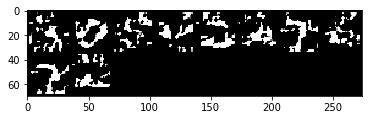

In [47]:
words = np.arange(10)
z = gen_noise(words.shape[0], words)
images = G(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()